In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import datetime
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import optuna
import eli5
from eli5.sklearn import PermutationImportance
import pickle
from IPython.display import clear_output
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from scipy.stats import norm
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.simplefilter("ignore")

# Validation

In [2]:
df_main = pd.read_excel('rating_dataset.xlsx', engine='openpyxl')
df_main.sort_values(['company', 'date'], inplace=True)
df_main['default'] = df_main['default'].replace({'отозв.': 1, 'ликв.': 1}).astype(float)

# Сброс индекса
df_main.reset_index(drop=True, inplace=True)

# Создание маски для ситуаций, когда в предыдущей строке было 1, а в следующей 0
mask = (df_main['default'].diff() == -1)

# Создание маски для ситуаций, когда компания в следующей строке такая же, как в предыдущей
same_company = df_main['company'] == df_main['company'].shift()

# Выбор строк, где обе маски истинны
result = df_main[mask & same_company]
df_main = df_main.drop(result.index)

df_main.sort_values(['company', 'date'], inplace=True)
df_main.reset_index(drop=True, inplace=True)

In [3]:
cols_fin = ['net_assets', 'ROA', 'liquid', 'ibl',
       'stocks', 'bond', 'oth_cap', 'sunk_retail_credit', 'NI',
       'organization_credit', 'sunk_organization_credit', 'credit_portf',
       'sunk_credit_portf', 'organization_deposit', 'retail_deposit',
       'security_tot', 'ROE', 'retail_credit', 'reserv_credit_perc',
       'zalog_credit_perc', 'foreign_na_fr', 'retail_deposit_fr', 'N3', 'N2',
       'N1', 'capital', 'msk_spb', 'INF_SA', 'NX_growth', 'micex_std',
       'miacr_std', 'miacr_amount', 'usd_rub_std_diff', 'micex_return',
       'net_foreign_assets_diff', 'net_gov_debt_diff', 'other_fin_debt_diff',
       'retail_debt_SA_DETREND_diff', 'stocks_capital_diff',
       'i_retail_spread_diff', 'usd_rub_return', 'miacr_diff']

cols_rat = ['rating_AKM_rus', 'rating_exra_rus',
       'rating_fitch_long', 'rating_fitch_rus', 'rating_moody_long',
       'rating_moody_rus', 'rating_NRA_rus', 'rating_rusrate',
       'rating_rusrate_rus', 'rating_sp_long', 'rating_sp_rus',
       'rating_sp_short', 'rating_AKM_rus_shift_1', 'rating_AKM_rus_shift_3', 'rating_AKM_rus_shift_6', 'rating_AKM_rus_shift_12', 'rating_AKM_rus_diff_1', 'rating_AKM_rus_diff_3', 'rating_AKM_rus_diff_6', 'rating_AKM_rus_diff_12', 'rating_exra_rus_shift_1', 'rating_exra_rus_shift_3', 'rating_exra_rus_shift_6', 'rating_exra_rus_shift_12', 'rating_exra_rus_diff_1', 'rating_exra_rus_diff_3', 'rating_exra_rus_diff_6', 'rating_exra_rus_diff_12', 'rating_fitch_long_shift_1', 'rating_fitch_long_shift_3', 'rating_fitch_long_shift_6', 'rating_fitch_long_shift_12', 'rating_fitch_long_diff_1', 'rating_fitch_long_diff_3', 'rating_fitch_long_diff_6', 'rating_fitch_long_diff_12', 'rating_fitch_rus_shift_1', 'rating_fitch_rus_shift_3', 'rating_fitch_rus_shift_6', 'rating_fitch_rus_shift_12', 'rating_fitch_rus_diff_1', 'rating_fitch_rus_diff_3', 'rating_fitch_rus_diff_6', 'rating_fitch_rus_diff_12', 'rating_moody_long_shift_1', 'rating_moody_long_shift_3', 'rating_moody_long_shift_6', 'rating_moody_long_shift_12', 'rating_moody_long_diff_1', 'rating_moody_long_diff_3', 'rating_moody_long_diff_6', 'rating_moody_long_diff_12', 'rating_moody_rus_shift_1', 'rating_moody_rus_shift_3', 'rating_moody_rus_shift_6', 'rating_moody_rus_shift_12', 'rating_moody_rus_diff_1', 'rating_moody_rus_diff_3', 'rating_moody_rus_diff_6', 'rating_moody_rus_diff_12', 'rating_NRA_rus_shift_1', 'rating_NRA_rus_shift_3', 'rating_NRA_rus_shift_6', 'rating_NRA_rus_shift_12', 'rating_NRA_rus_diff_1', 'rating_NRA_rus_diff_3', 'rating_NRA_rus_diff_6', 'rating_NRA_rus_diff_12', 'rating_rusrate_shift_1', 'rating_rusrate_shift_3', 'rating_rusrate_shift_6', 'rating_rusrate_shift_12', 'rating_rusrate_diff_1', 'rating_rusrate_diff_3', 'rating_rusrate_diff_6', 'rating_rusrate_diff_12', 'rating_rusrate_rus_shift_1', 'rating_rusrate_rus_shift_3', 'rating_rusrate_rus_shift_6', 'rating_rusrate_rus_shift_12', 'rating_rusrate_rus_diff_1', 'rating_rusrate_rus_diff_3', 'rating_rusrate_rus_diff_6', 'rating_rusrate_rus_diff_12', 'rating_sp_long_shift_1', 'rating_sp_long_shift_3', 'rating_sp_long_shift_6', 'rating_sp_long_shift_12', 'rating_sp_long_diff_1', 'rating_sp_long_diff_3', 'rating_sp_long_diff_6', 'rating_sp_long_diff_12', 'rating_sp_rus_shift_1', 'rating_sp_rus_shift_3', 'rating_sp_rus_shift_6', 'rating_sp_rus_shift_12', 'rating_sp_rus_diff_1', 'rating_sp_rus_diff_3', 'rating_sp_rus_diff_6', 'rating_sp_rus_diff_12', 'rating_sp_short_shift_1', 'rating_sp_short_shift_3', 'rating_sp_short_shift_6', 'rating_sp_short_shift_12', 'rating_sp_short_diff_1', 'rating_sp_short_diff_3', 'rating_sp_short_diff_6', 'rating_sp_short_diff_12']


oot = df_main[df_main['date'] >= '2017-05']
train = df_main[df_main['date'] < '2017-05']

X_train, X_val, y_train, y_val = train_test_split(train.drop(['date', 'company', 'number', 'default'], axis=1),
                                                  train.default,
                                                  test_size=0.2,
                                                  random_state=42)

## Data

Бизнес-задача: формирование портфеля банков для дальнейших инвестиций, а также подсчет вероятности наступления целевого события у прогнозируемого банка. Для решения задачи была выбрана метрика ROC-AUC (GINI), которая ранжирует наблюдения по уверенности в наступлении целевого события, а также позволяет корректно оценить вероятности прогнозов после проведения калибровки. Нам достаточно выделить top-N банков, в которые можно сделать вложения. Кроме того, для дальнейшего выполнения задания необходимо оценить вероятности наступления целевых событий

Данные для построения модели были взяты месячные данные о финансовых показателях банков и оценки их надежности российскими и зарубежными рейтинговыми агентствами. Данные из открытых источников сайт ЦБ, сайт Банки.ру, github

Алгоритм формирования выборки исключает появление лика данных, тк данные за конец 2017 года используются только в качестве формирования таргета, а признаковое описание наблюдений затрагивает период представленный ниже. 

В силу количества и качества данных (рейтинговые данные доступны не за каждый временной промежуток и многие агентства не публиковали свои рейтинги после 2018-19гг) за целевую событие был взят факт отзыва или ликвидации лицензии у банка на горизонте 3 месяцев с момента предсказания:
1) С точки зрения вложений нам все равно, какова причина прекращения работы банка, поэтому взятие обеих причин в качестве целевой переменной состыкуются с бизнес-задачей
2) С точки зрения выбора горизонта прогнозирования - такой выбор обоснован размером имеющегося датасета. Кроме того, в задачах с сильным дизбалансом классов моделям сложнее улавливать реальные зависимости между переменными и таргетом. Горизонт планирования в 3 месяца позволяет сохранить определенный баланс между адекватным сроком прогнозирования (не слишком коротким) и взаимосвязью признаков и таргета

In [4]:
print(f'Дата начала TRAIN периода: {train["date"].min()}')
print(f'Дата окончания TRAIN периода: {train["date"].max()}')
print(f'Дата начала OOT периода: {oot["date"].min()}')
print(f'Дата окончания OOT периода: {oot["date"].max()}')

Дата начала TRAIN периода: 2015-01
Дата окончания TRAIN периода: 2017-04
Дата начала OOT периода: 2017-05
Дата окончания OOT периода: 2017-12


In [5]:
print(f'Среднее значение целевой переменной на TRAIN выборке: {round(y_train.mean(), 4)}')
print(f'Среднее значение целевой переменной на VAL выборке: {round(y_val.mean(), 4)}')
print(f'Среднее значение целевой переменной на OOT выборке: {round(oot.default.mean(), 4)}')

Среднее значение целевой переменной на TRAIN выборке: 0.0248
Среднее значение целевой переменной на VAL выборке: 0.0175
Среднее значение целевой переменной на OOT выборке: 0.0142


In [6]:
print(f'Количество наблюдений в TRAIN выборке: {X_train.shape[0]}')
print(f'Количество наблюдений в VAL выборке: {X_val.shape[0]}')
print(f'Количество наблюдений в OOT выборке: {oot.shape[0]}')

Количество наблюдений в TRAIN выборке: 5252
Количество наблюдений в VAL выборке: 1314
Количество наблюдений в OOT выборке: 1059


In [7]:
print(f'Количество целевых событий в TRAIN выборке: {y_train.sum()}')
print(f'Количество целевых событий в VAL выборке: {y_val.sum()}')
print(f'Количество целевых событий в OOT выборке: {oot.default.sum()}')

Количество целевых событий в TRAIN выборке: 130.0
Количество целевых событий в VAL выборке: 23.0
Количество целевых событий в OOT выборке: 15.0


Text(0, 0.5, 'Target_rate')

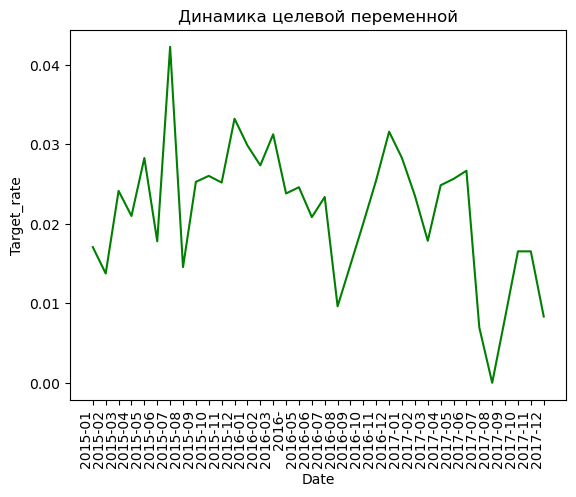

In [8]:
targets = df_main.sort_values(by='date').groupby('date')['default'].agg('mean').values
dates = ['2015-01', '2015-02', '2015-03', '2015-04',
       '2015-05', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-',
       '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04',
       '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12']

plt.plot(dates, targets, color='green')
plt.title('Динамика целевой переменной')
plt.xticks(rotation=90, ha='right')
plt.xlabel('Date')
plt.ylabel('Target_rate')

По графику видно, что на ООТ таргет ведет себя по-другому, относительно предыдущих временных периодов, что затрудняет прогнозы модели

## Data Quality

Используемые данные характеризуются отсутствием пересечений в выборках.

Заполнение пропусков в данных по рейтингам проводилось на основе последнего известного значения по каждому рейтинговому агентству для каждого банка. Такой подход связан в первую очередь с особенностями данных: сами рейтинговые агенства прогнозируют надежность на несколько периодов вперед, что подразумевает, что их рейтинги будут актуальны эти несколько периодов. А смена рейтинга не "По расписанию" может свидетельствовать о сильных изменениях в конкретном наблюдении

Данные характеризуются плохой актуальностью: вследствие плохого качества отчетов многих банков по большой части выборки не удалось найти согласованные данные в едином реестре за период после 2018 года. Кроме того, большинство рейтинговых агентств перестало выкладывать информацию о финансовых организациях из России (за исключением самых крупных банков). Период 2015-2018гг характеризовался более стабильным состоянием экономики чем периоды 2013-14гг и 2019-2024гг, что осложняет задачу построения качественной модели.

Тем не менее, качество используемых данных можно оценить на уровне желтого светофора

## Metrics test

In [1]:
short_list_rat = ['rating_exra_rus',
 'rating_exra_rus_shift_3',
 'rating_rusrate_rus',
 'rating_AKM_rus',
 'rating_NRA_rus_diff_3',
 'rating_exra_rus_shift_6',
 'rating_moody_long',
 'rating_exra_rus_diff_6',
 'rating_exra_rus_shift_1',
 'rating_NRA_rus_diff_6',
 'rating_exra_rus_diff_1',
 'rating_exra_rus_shift_12',
 'rating_exra_rus_diff_12',
 'rating_NRA_rus_shift_3',
 'rating_AKM_rus_diff_12',
 'rating_NRA_rus',
 'rating_fitch_long',
 'rating_NRA_rus_diff_12']

In [2]:
print(*short_list_rat, sep='\n')

rating_exra_rus
rating_exra_rus_shift_3
rating_rusrate_rus
rating_AKM_rus
rating_NRA_rus_diff_3
rating_exra_rus_shift_6
rating_moody_long
rating_exra_rus_diff_6
rating_exra_rus_shift_1
rating_NRA_rus_diff_6
rating_exra_rus_diff_1
rating_exra_rus_shift_12
rating_exra_rus_diff_12
rating_NRA_rus_shift_3
rating_AKM_rus_diff_12
rating_NRA_rus
rating_fitch_long
rating_NRA_rus_diff_12


In [10]:
with open('model_fin.pkl', 'rb') as f:
    model1 = pickle.load(f)

with open('CB_rating_model.pkl', 'rb') as f:
    model2 = pickle.load(f)

with open('sfm.pkl', 'rb') as f:
    enc = pickle.load(f)

In [11]:
df_main['score_finance'] = model1.predict_proba(enc.transform(df_main[cols_fin]))[:, 1]
df_main['score_ratings'] = model2.predict_proba(df_main[short_list_rat])[:, 1]

OOT = df_main[df_main['date'] >= '2017-05']
TRAIN = df_main[df_main['date'] < '2017-05']

In [12]:
print(f'OOT ROC-AUC Finance: {roc_auc_score(OOT.default, OOT.score_finance)}')
print(f'OOT ROC-AUC Ratings: {roc_auc_score(OOT.default, OOT.score_ratings)}')

OOT ROC-AUC Finance: 0.7441890166028098
OOT ROC-AUC Ratings: 0.8971264367816092


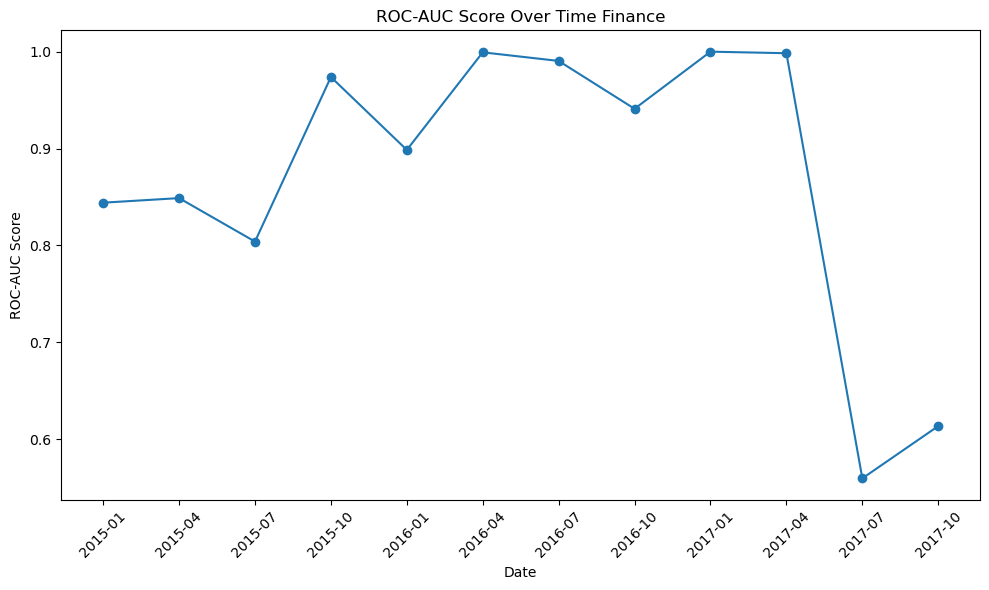

In [13]:
df_sorted = df_main.sort_values(by='date')

dates = df_sorted['date'].unique().tolist()
roc_auc_scores = []

for i in range(len(dates)):
    if i % 3 == 0:
        try:
            roc_auc = roc_auc_score(df_main[(df_main['date'] == dates[i])]['default'], df_main[df_main['date'] == dates[i]]['score_finance'])
        except:
            roc_auc = roc_auc_score(OOT.default, OOT.score_finance)
        roc_auc_scores.append(roc_auc)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(dates[::3], roc_auc_scores, marker='o')
plt.xlabel('Date')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Score Over Time Finance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

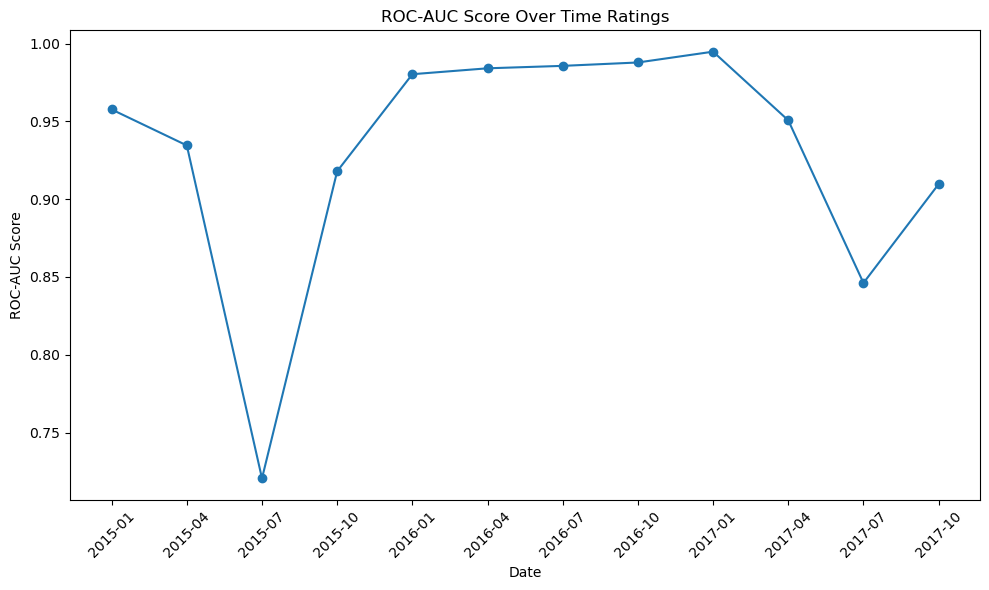

In [14]:
df_sorted = df_main.sort_values(by='date')

dates = df_sorted['date'].unique().tolist()
roc_auc_scores = []

for i in range(len(dates)):
    if i % 3 == 0:
        try:
            roc_auc = roc_auc_score(df_main[(df_main['date'] == dates[i])]['default'], df_main[df_main['date'] == dates[i]]['score_ratings'])
        except:
            roc_auc = roc_auc_score(OOT.default, OOT.score_finance)
        roc_auc_scores.append(roc_auc)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(dates[::3], roc_auc_scores, marker='o')
plt.xlabel('Date')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Score Over Time Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Calibration

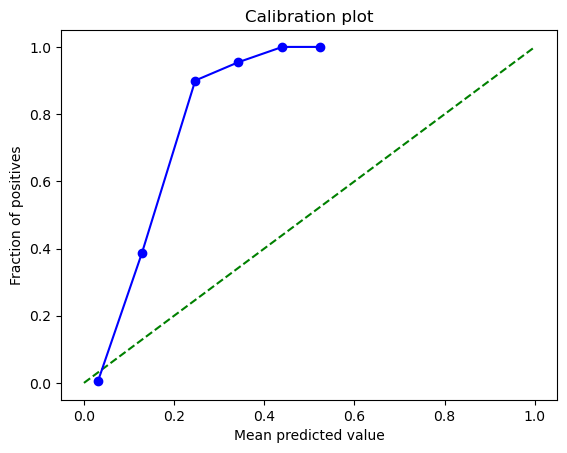

In [15]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Model perfectly calibrated", color='green')
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot')

prob_pos = df_main['score_finance']
model_score = brier_score_loss(df_main.default, prob_pos, pos_label=df_main.default.max())
fraction_of_positives, mean_predicted_value = calibration_curve(df_main.default, prob_pos, n_bins=10)
ax.plot(mean_predicted_value, fraction_of_positives, "go-", color='blue', label=f'Model Finance ({round(model_score, 4)})')

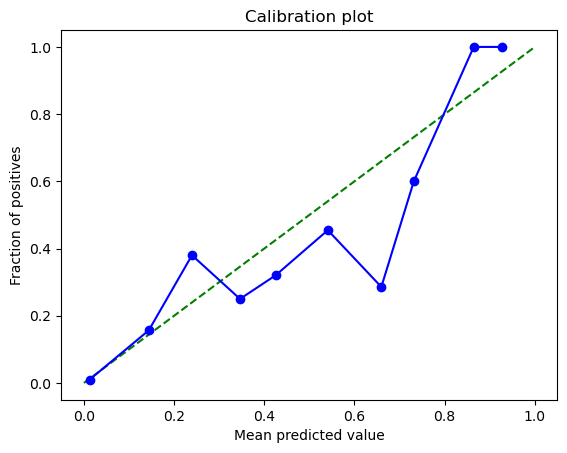

In [16]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Model perfectly calibrated", color='green')
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot')

prob_pos = df_main['score_ratings']
model_score = brier_score_loss(df_main.default, prob_pos, pos_label=df_main.default.max())
fraction_of_positives, mean_predicted_value = calibration_curve(df_main.default, prob_pos, n_bins=10)
ax.plot(mean_predicted_value, fraction_of_positives, "go-", color='blue', label=f'Model Ratings ({round(model_score, 4)})')

In [17]:
X_train_fin = enc.transform(X_train[cols_fin])
X_oot = oot[cols_fin]

target_cols = 'default'
base_metric = roc_auc_score(y_train, model1.predict_proba(X_train_fin)[:, -1])
feature_importances = {}
for col in tqdm(X_train[cols_fin].columns):
    X_train_1 = X_train.copy()
    X_train_1[col] = X_train_1[col].sample(frac=1,random_state=13).reset_index(drop=True)
    X_train_fin = enc.transform(X_train_1[cols_fin])
    feature_importances[col] = base_metric - roc_auc_score(y_train, model1.predict_proba(X_train_fin)[:, -1])
features_ordered = list(list(zip(*sorted(feature_importances.items(),key=lambda tpl: tpl[1], reverse=True)))[0])
features_step = 2
results_dct_oot = {}
results_dct_train = {}
results_train = []
results_oot = []
num_factors=len(X_train[cols_fin].columns)
tickets=np.arange(1,(num_factors+num_factors%features_step+features_step)//features_step)*features_step+num_factors%features_step

for i, features_number in tqdm(enumerate(tickets[::-1])):
    clear_output(wait=True)
    features_curr = features_ordered[:features_number]
    model_new = model1
    model_new.fit(X_train[features_curr],y_train, verbose=False)
    thresholds = sorted(model_new.feature_importances_, reverse=True)[-1]
    sfm = SelectFromModel(model_new, threshold=thresholds)
    X_train_sfm = sfm.fit_transform(X_train[features_curr], y_train)
    X_val_sfm = sfm.transform(X_val[features_curr])
    X_oot_sfm = sfm.transform(X_oot[features_curr])
    model_new.fit(X_train_sfm, y_train, eval_set=[(X_val_sfm, y_val)], early_stopping_rounds=10, verbose=True)
    results_dct_train[features_number] = roc_auc_score(y_train, model_new.predict_proba(X_train_sfm)[:, -1]) * 100
    results_dct_oot[features_number] = roc_auc_score(oot.default, model_new.predict_proba(X_oot_sfm)[:, -1]) * 100
    results_train.append(roc_auc_score(y_train, model_new.predict_proba(X_train_sfm)[:, -1]) *100)
    results_oot.append(roc_auc_score(oot.default, model_new.predict_proba(X_oot_sfm)[:, -1])*100)

[0]	validation_0-auc:0.61343
[1]	validation_0-auc:0.62845
[2]	validation_0-auc:0.62660
[3]	validation_0-auc:0.62335
[4]	validation_0-auc:0.61971
[5]	validation_0-auc:0.60119
[6]	validation_0-auc:0.60302
[7]	validation_0-auc:0.60159
[8]	validation_0-auc:0.59959
[9]	validation_0-auc:0.59800
[10]	validation_0-auc:0.60651
[11]	validation_0-auc:0.60432


21it [00:19,  1.09it/s]


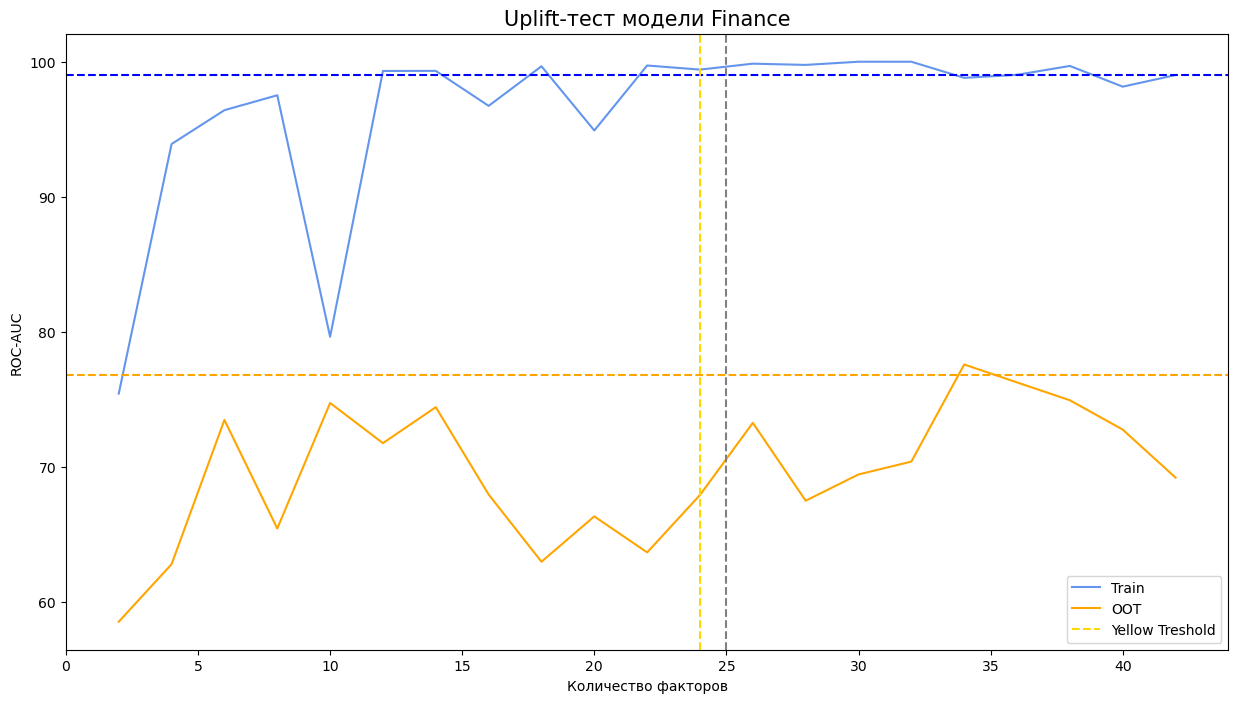

In [18]:
fig,ax=plt.subplots(figsize=(15,8))
ax.set_title('Uplift-тест модели Finance',fontsize=15)
ax.set_ylabel('ROC-AUC')
ax.set_xlabel('Количество факторов')
ax.plot(tickets[:],results_train[::-1],label='Train',color='cornflowerblue')
ax.plot(tickets[:],results_oot[::-1],label='OOT',color='orange')
ax.axvline(int(0.6 * len(features_ordered)), linestyle="dashed", color="gray")
ax.axhline(max(results_train) * 0.99, linestyle="dashed", color="blue")
ax.axhline(max(results_oot) * 0.99, linestyle="dashed", color="orange")
yellow_numbers=[val for val in tickets if val<=len(features_ordered)*0.6]
ax.axvline(yellow_numbers[-1],color='gold',linestyle='--',label='Yellow Treshold')
ax.legend(loc='best')
plt.show()

Выбор первых 26 фичей оправдан, так как соблюдается баланс между скором модели и меньшим количеством факторов. Однако спецификация модели оценивается на уровне желтого светофора, тк есть меньший набор факторов, который показывает не худший результат

In [19]:
X_train_rat = X_train[cols_rat]
X_oot = oot[cols_rat]

base_metric = roc_auc_score(y_train, model2.predict_proba(X_train_rat)[:, -1])
feature_importances = {}
for col in tqdm(X_train_rat.columns):
    X_train_1 = X_train_rat.copy()
    X_train_1[col] = X_train_1[col].sample(frac=1,random_state=13).reset_index(drop=True)
    feature_importances[col] = base_metric - roc_auc_score(y_train, model2.predict_proba(X_train_1)[:, -1])
features_ordered = list(list(zip(*sorted(feature_importances.items(),key=lambda tpl: tpl[1], reverse=True)))[0])
features_step = 2
results_dct_oot = {}
results_dct_train = {}
results_train = []
results_oot = []
num_factors=len(X_train_rat.columns)
tickets=np.arange(1,(num_factors+num_factors%features_step+features_step)//features_step)*features_step+num_factors%features_step

for i, features_number in tqdm(enumerate(tickets[::-1])):
    clear_output(wait=True)
    features_curr = features_ordered[:features_number]
    model_new = model2
    model_new.fit(X_train_rat[features_curr],y_train, verbose=False)
    results_dct_train[features_number] = roc_auc_score(y_train, model_new.predict_proba(X_train_rat[features_curr])[:, -1]) * 100
    results_dct_oot[features_number] = roc_auc_score(oot.default, model_new.predict_proba(X_oot[features_curr])[:, -1]) * 100
    results_train.append(roc_auc_score(y_train, model_new.predict_proba(X_train_rat[features_curr])[:, -1]) *100)
    results_oot.append(roc_auc_score(oot.default, model_new.predict_proba(X_oot[features_curr])[:, -1])*100)

54it [05:28,  6.09s/it]


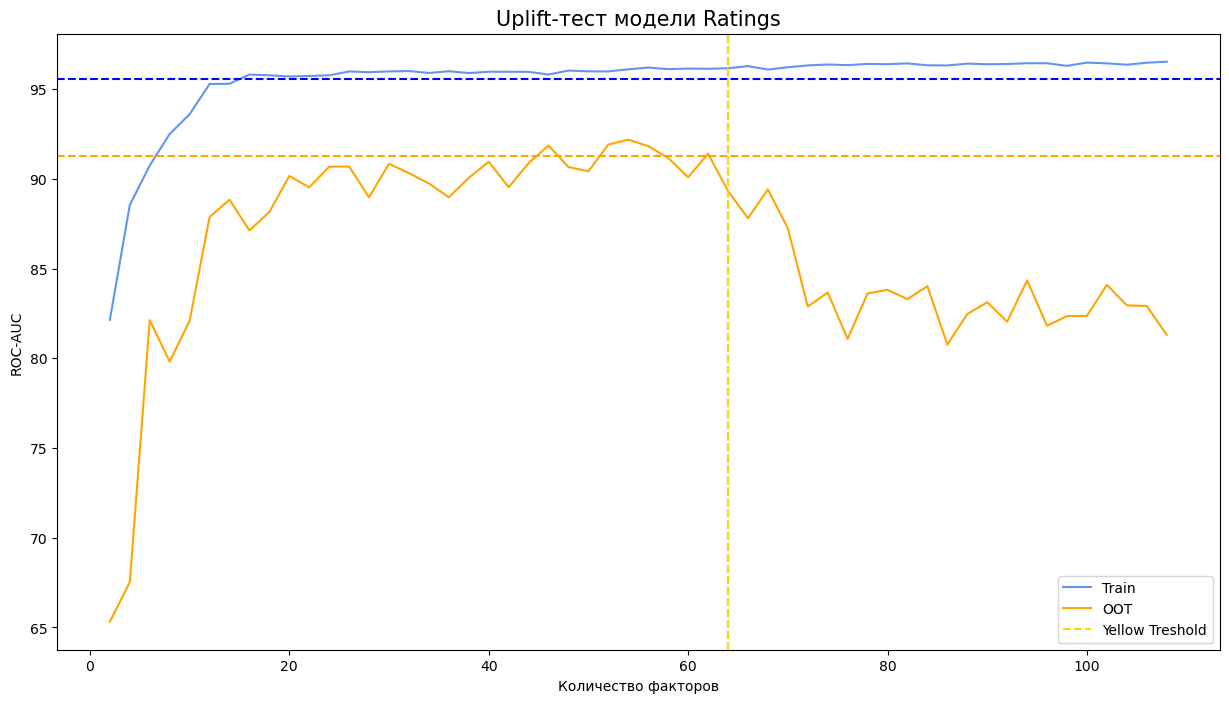

In [20]:
fig,ax=plt.subplots(figsize=(15,8))
ax.set_title('Uplift-тест модели Ratings',fontsize=15)
ax.set_ylabel('ROC-AUC')
ax.set_xlabel('Количество факторов')
ax.plot(tickets[:],results_train[::-1],label='Train',color='cornflowerblue')
ax.plot(tickets[:],results_oot[::-1],label='OOT',color='orange')
ax.axvline(int(0.6 * len(features_ordered)), linestyle="dashed", color="gray")
ax.axhline(max(results_train) * 0.99, linestyle="dashed", color="blue")
ax.axhline(max(results_oot) * 0.99, linestyle="dashed", color="orange")
yellow_numbers=[val for val in tickets if val<=len(features_ordered)*0.6]
ax.axvline(yellow_numbers[-1],color='gold',linestyle='--',label='Yellow Treshold')
ax.legend(loc='best')
plt.show()

Выбор первых 18 фичей оправдан и соответствует зеленому светофору за спецификацию модели

## Model Stability

In [24]:
print(f'OOT ROC-AUC Finance: {roc_auc_score(OOT.default, OOT.score_finance)}')
print(f'TRAIN ROC-AUC Finance: {roc_auc_score(TRAIN.default, TRAIN.score_finance)}')
print(f'-----------------------------------------------')
print(f'Разница между ранжирующей способностью модели на ООТ и TRAIN:')
print((roc_auc_score(TRAIN.default, TRAIN.score_finance) - roc_auc_score(OOT.default, OOT.score_finance))/roc_auc_score(TRAIN.default, TRAIN.score_finance))

OOT ROC-AUC Finance: 0.7441890166028098
TRAIN ROC-AUC Finance: 0.957302313825369
-----------------------------------------------
Разница между ранжирующей способностью модели на ООТ и TRAIN:
0.22261859617884025


Отклонения предсказаний в чуть более чем 20% удовлетворительно и соответствует желтому светофору за стабильность

In [25]:
print(f'OOT ROC-AUC Ratings: {roc_auc_score(OOT.default, OOT.score_ratings)}')
print(f'TRAIN ROC-AUC Ratings: {roc_auc_score(TRAIN.default, TRAIN.score_ratings)}')
print(f'-----------------------------------------------')
print(f'Разница между ранжирующей способностью модели на ООТ и TRAIN:')
print((roc_auc_score(TRAIN.default, TRAIN.score_ratings) - roc_auc_score(OOT.default, OOT.score_ratings))/roc_auc_score(TRAIN.default, TRAIN.score_ratings))

OOT ROC-AUC Ratings: 0.8971264367816092
TRAIN ROC-AUC Ratings: 0.949427174581044
-----------------------------------------------
Разница между ранжирующей способностью модели на ООТ и TRAIN:
0.055086624018860275


Отклонения предсказаний в чуть более чем 5% соответствует зеленому светофору за стабильность